# Simulating a galaxy survey

In this exercise, we will simulate a galaxy survey for cosmic shear with a software package called [GLASS](https://glass.readthedocs.io/).
More specifically, we will create simulated maps of the cosmic matter density, and the weak lensing fields of convergence and shear.

## Set up

Modern cosmological surveys cover very large parts of the sky, and so must our simulation. That means we have to work on the sphere, and not flat space. To do so, we use a pixelisation of the sphere called [HEALPix](https://en.wikipedia.org/wiki/HEALPix), which is the de facto standard format for full-sky maps in cosmology. We can use the `healpy` package to work with HEALPix maps.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

The most important fact about HEALPix is that every map has a resolution, given by the so-called $\mathtt{NSIDE}$ parameter. A HEALPix map is a simple array of $12 \, \mathtt{NSIDE}^2$ numbers, one for each pixel. And each pixel has a fixed and known position in the sky.

> What is the pixel size of a HEALPix map at a given $\mathtt{NSIDE}$ parameter? Hint: The area of the unit sphere is $\frac{60^4}{100\pi}$ deg$^2$, $\frac{60^6}{100\pi}$ arcmin$^2$, and $\frac{60^8}{100\pi}$ arcsec$^2$.

## Survey

We start by characterising the galaxy survey that we wish to simulate. Any real galaxy survey will not observe the entire sky, but only a fraction. To model this, we create a HEALPix map of the footprint of our survey.

In [2]:
# resolution of our simulation
nside = 1024

# get longitude and latitude of all HEALPix pixels
lon, lat = hp.pix2ang(nside, np.arange(12 * nside**2), lonlat=True)

# create a footprint by selecting pixels in the desired RA and Dec range
fp = (((lon > 329.5) | (lon < 53.5)) & ((-45.6 < lat) & (lat < -15.7))) * 1.0

The `healpy` package comes with a number of visualisations for HEALPix maps, which we can use to show the footprint that we generated.

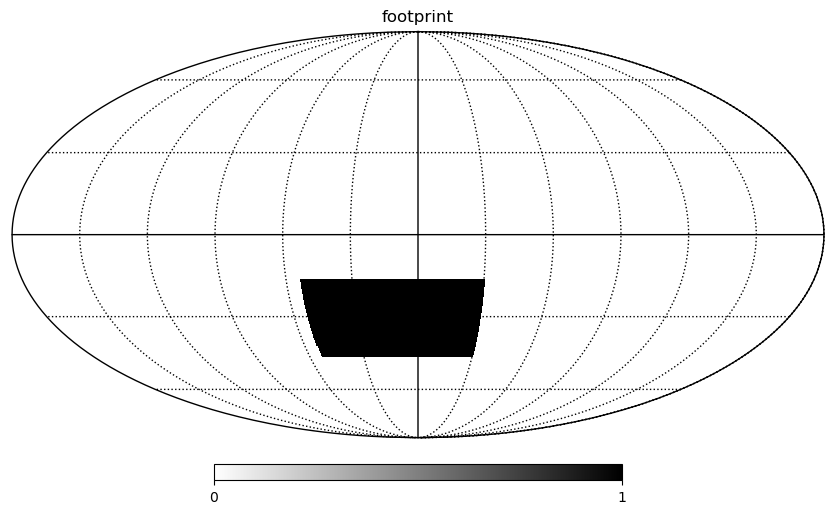

In [3]:
# show the footprint we created on the full sky
hp.mollview(fp, title="footprint", cmap="binary")
hp.graticule(c="k")
plt.show()

> How can you calculate the fraction of the sky that this footprint covers? Hint: what is the sky fraction if half of the footprint values are 1.0, and half are 0.0?

> What is the footprint area in deg$^2$?

We save the simulated footprint to disk for later use.

In [4]:
hp.write_map("footprint.fits.gz", fp, dtype=np.float32, fits_IDL=False, column_names=["FOOTPRINT"], overwrite=True)

Just as important as the angular selection is the radial one. That is encoded in the normalised redshift distribution $n(z)$ of the observed galaxies. Here, we use a redshift distribution that comes with GLASS.

In [5]:
from glass.observations import smail_nz

# true redshift distribution following a Smail distribution
z = np.arange(0., 3.0, 0.005)
nz = smail_nz(z, z_mode=0.9, alpha=2.0, beta=1.5)

In [6]:
# check that n(z) is normalised
np.trapz(nz, z)

1.0

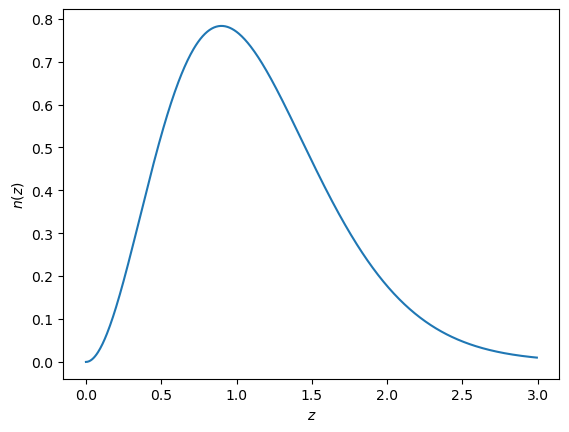

In [7]:
# plot the redshift distribution
plt.plot(z, nz)
plt.xlabel("$z$")
plt.ylabel("$n(z)$")
plt.show()

A further survey characteristic is the observed galaxy density, which directly determines the noise level of the eventual cosmic shear measurements. The galaxy density is commonly quoted as galaxies per arcmin$^2$.

When simulating galaxies, GLASS works with the galaxy number distribution $dN/dz$, which is $n(z)$ scaled by the total galaxy density.

In [8]:
# survey galaxy density in galaxies/arcmin2
galaxy_density = 1.0

# galaxy number distribution
dndz = galaxy_density * nz

In [9]:
# check that dndz recovers galaxy_density
np.trapz(dndz, z)

1.0

In the simulation, we will sample galaxies from the true redshift distribution $dN/dz$ of the survey.  However, galaxies in a real photometric galaxy survey do not come with true or spectroscopic redshifts, but only with photometric redshifts that have a rather large uncertainty.  Here, we simulate the photometric redshift uncertainty as a Gaussian error with standard deviation $\sigma(z) = (1 + z) \, \sigma_0$, where $\sigma_0$ is a characteristic of the survey.

In [10]:
# photometric redshift error model
from glass.galaxies import gaussian_phz

# photometric redshift error at redshift zero
sigma_z0 = 0.03

The final survey characteristic is the so-called "shape noise" of galaxies, which is the standard deviation $\sigma_e$ of the intrinsic galaxy ellipticities, before they are sheared. Here, we will use one of GLASS's models for the intrinsic ellipticity, and a value of $\sigma_e$ that is fairly representative of current cosmic shear surveys.

In [11]:
# intrinsic ellipticity model
from glass.shapes import ellipticity_intnorm

# ellipticity standard deviation per component
sigma_e = 0.25

Footprint, redshift distribution, galaxy density, photometric redshift errors, and shape noise — these are the quantities that characterise a cosmic shear survey.

## Cosmology

Next, we need to set up the cosmology that we wish to simulate. This will then be used by the code to compute, e.g., the cosmological distance functions.

There are many cosmological codes in use. Here, we use CAMB, which is nicely integrated with GLASS. We only set $H_0$ and $\Omega_m = \Omega_c + \Omega_b$ here, and leave everything else set to the default values that CAMB uses.

In [12]:
import camb
from cosmology import Cosmology

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get a cosmology object from CAMB
cosmo = Cosmology.from_camb(pars)

## Simulation set up

To set up the simulation, we first need to create a redshift grid. That grid will define individual matter shells that GLASS simulates:

![GLASS shells](https://glass.readthedocs.io/stable/_images/spheres.png)

We also have to give each shell a radial profile. GLASS offers a number of choices here:

![shell profiles](https://glass.readthedocs.io/stable/_images/how-glass-works-2.svg)

Instead of giving each shell the commonly used tophat profile, we use overlapping triangular shells. This leads to a much better match when simulating galaxies with a smooth $n(z)$, as well as a much improved weak lensing signal.

In [13]:
from glass.shells import distance_grid, linear_windows

# shells of 200 Mpc in comoving distance spacing
zgrid = distance_grid(cosmo, 0.0, 3.0, dx=200.)

# tophat window functions for shells
shells = linear_windows(zgrid)

What GLASS is primarily simulating is the large-scale structure of the universe, from which everything else (lensing, galaxies) follows. However, we cannot make our simulation infinitely detailed: there must be a scale at which we stop. For a simulation on the sphere, this is an angular scale, expressed in terms of an angular mode number $\ell_{\max}$. Similar to a wavenumber $k$ in a Fourier expansion, the number $\ell$ is something like an "inverse angle"; however, in harmonic space (i.e., the equivalent of Fourier space on the sphere), the relation is somewhat more complicated than one-over-angle. For now, we just pick a suitable number: `lmax = 2000` is at very small scales, so our simulation will cover more or less what current galaxy surveys can measure.

In [14]:
# the angular modes we want to simulate
lmax = 2000

GLASS is not an $N$-body code; it has no idea about the physical processes that shape the universe. Instead, it is a "statistical simulation", which can generate random matter shells that look very much like the output from $N$-body codes, at least at the one-point and two-point level that we are interested here.

To do so, GLASS needs to know the expected two-point statistics of large-scale structure in each matter shell. That must be computed from a theory code such as CAMB. Then, we need to assume a one-point distribution (i.e., the distribution of values) of matter; the shifted lognormal distribution is a well-established choice. Given these two pieces of information, GLASS can figure out how to simulate a mock universe.

Unfortunately, computing the expected two-point statistics for large-scale structure in a large number of shells takes a fair amount of time. We can pre-compute the results and reuse them; but you will need to recompute if you change the cosmology or shell definition.

In [15]:
# set this to True to recompute inputs, then False after
recompute = False

In [16]:
from glass.ext.camb import matter_cls
from glass.fields import lognormal_gls
from glass.user import load_cls, save_cls

if recompute:
    # compute the angular matter power spectra of the shells with CAMB
    cls = matter_cls(pars, lmax, shells)

    # compute Gaussian cls for lognormal fields for 3 correlated shells
    # putting nside here means that the HEALPix pixel window function is applied
    gls = lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

    # store the lognormal spectra for later
    save_cls("gls.npz", gls)
else:
    # load previously computed lognormal spectra
    gls = load_cls("gls.npz")

Finally, there is one last piece of information that GLASS will need. We have generated our overall galaxy number density distribution $dN/dz$ above. We need to discretise this distribution, so that GLASS knows how many galaxies to simulate in each shell. This is done by partitioning $dN/dz$ over the radial profiles of each shell.

In [17]:
from glass.shells import partition

# compute the galaxies density for each bin in each shell
ngal = partition(z, dndz, shells)

In [18]:
# adding ngal should recover the total galaxy density
ngal.sum(), galaxy_density

(1.0000000000001574, 1.0)

## Running the simulation

Having completed all preparatory steps, it is time to run the simulation and write a catalogue. The overall structure of the code contains two loops: an outer loop over shells, and an inner loop over galaxies in each shell. The latter is done for efficiency reasons, since even the galaxies in a single shell can quickly exhaust all available memory, depending on the kind of simulation and survey.

> Take some time to go though the simulation code. Look at what each step does. Do you understand what is being simulated? Do you understand the kind of catalogue that is being produced?

In [19]:
from glass.fields import generate_lognormal
from glass.galaxies import galaxy_shear, redshifts
from glass.lensing import MultiPlaneConvergence, shear_from_convergence
from glass.points import positions_from_delta
from glass.user import write_catalog

# we write the catalogue to a FITS file as it is generated
with write_catalog("catalog.fits") as out:

    # generator for lognormal matter fields
    matter = generate_lognormal(gls, nside, ncorr=3)

    # this will compute the convergence field iteratively
    convergence = MultiPlaneConvergence(cosmo)

    # simulate the matter fields in the main loop, and build up the catalogue
    for i, delta in enumerate(matter):

        print(f"shell {i}, redshift {shells[i].zeff:.3f}")

        # compute the lensing maps for this shell
        convergence.add_window(delta, shells[i])
        kappa = convergence.kappa
        gamm1, gamm2 = shear_from_convergence(kappa)
    
        # generate galaxy positions from matter density contrast and footprint
        # this goes through all galaxies in batches
        for gal_lon, gal_lat, gal_count in positions_from_delta(ngal[i], delta, None, fp):

            print(f"+ {gal_count} galaxies")

            # generate random redshifts within the shells
            gal_z = redshifts(gal_count, shells[i])
    
            # generate photometric redshifts from the uncertainty model
            gal_phz = gaussian_phz(gal_z, sigma_z0)
    
            # generate galaxy ellipticities from the chosen distribution
            gal_eps = ellipticity_intnorm(gal_count, sigma_e)
    
            # apply the shear fields to the ellipticities
            gal_she = galaxy_shear(gal_lon, gal_lat, gal_eps, kappa, gamm1, gamm2)

            # uniform shear weights for this example
            gal_wht = np.random.uniform(0.0, 1.0, size=gal_eps.size)

            # write rows for this batch of galaxies
            out.write(
                RA=gal_lon,
                DEC=gal_lat,
                REDSHIFT=gal_z,
                PHZ=gal_phz,
                E1=gal_she.real,
                E2=gal_she.imag,
                WEIGHT=gal_wht,
            )

shell 0, redshift 0.047
+ 2144 galaxies
shell 1, redshift 0.095
+ 11072 galaxies
shell 2, redshift 0.145
+ 27747 galaxies
shell 3, redshift 0.196
+ 48434 galaxies
shell 4, redshift 0.248
+ 76375 galaxies
shell 5, redshift 0.302
+ 106164 galaxies
shell 6, redshift 0.357
+ 143251 galaxies
shell 7, redshift 0.414
+ 186764 galaxies
shell 8, redshift 0.473
+ 230504 galaxies
shell 9, redshift 0.535
+ 273703 galaxies
shell 10, redshift 0.598
+ 319037 galaxies
shell 11, redshift 0.665
+ 364199 galaxies
shell 12, redshift 0.733
+ 400143 galaxies
shell 13, redshift 0.805
+ 439216 galaxies
shell 14, redshift 0.880
+ 463052 galaxies
shell 15, redshift 0.959
+ 482216 galaxies
shell 16, redshift 1.041
+ 492679 galaxies
shell 17, redshift 1.128
+ 492137 galaxies
shell 18, redshift 1.219
+ 479687 galaxies
shell 19, redshift 1.314
+ 456167 galaxies
shell 20, redshift 1.416
+ 423091 galaxies
shell 21, redshift 1.522
+ 383204 galaxies
shell 22, redshift 1.635
+ 335092 galaxies
shell 23, redshift 1.755
+ 

We can load the catalogue we just wrote to check it is as we expect it to be.

In [20]:
import fitsio

# read the catalogue
cat = fitsio.read("catalog.fits")

In [21]:
# get the column names
cat.dtype.names

('RA', 'DEC', 'REDSHIFT', 'PHZ', 'E1', 'E2', 'WEIGHT')

In [22]:
# get the catalogue size
cat.size

7698208

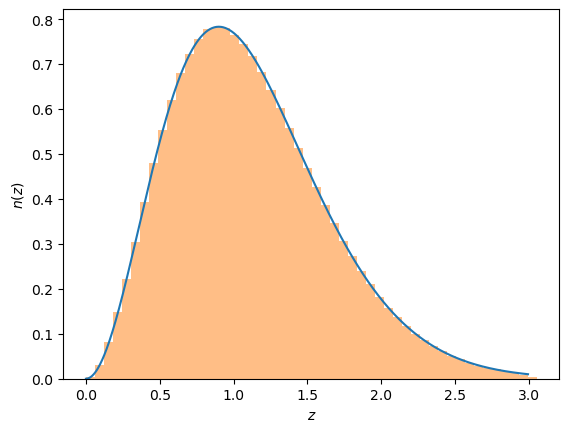

In [23]:
# check the realised redshift distribution
plt.plot(z, nz)
plt.hist(
    cat["REDSHIFT"],
    histtype="stepfilled",
    ec="none",
    alpha=0.5,
    bins=50,
    density=True,
)
plt.xlabel("$z$")
plt.ylabel("$n(z)$")
plt.show()

> Is the catalogue size as expected?

> Modern surveys observe hundreds of millions of galaxies. What can you change to make this simulation more realistic?

> Before going to the second part, simulate a survey with 10x as many galaxies.